# Introduction

La transmission de la COVID-19 se fait notamment par les micro-gouttelettes que l’on projette dans l’air, en respirant ou en parlant. En se couvrant le nez et la bouche, jusqu’au menton, avec un masque, on limite la quantité de micro-gouttelettes que l’on projette autour de nous et donc on lutte contre la propagation de ce virus.

néanmoins, il y a des gens qui ne respectent pas cette mesure. en y pensant, je me suis rendu compte que ça pourrait être intéressant d'immobiliser l'intelligence artificielle afin de détecter les gens qui ne mettent pas un masque ou qui le mettent de manière incorrecte.

# Préparation de l'environnement

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os, shutil, pickle, json
import cv2

# import beautifulsoup to parse xml files
from bs4 import BeautifulSoup

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import common detectron2 utilities
import detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

/home/mounta/Bureau/Personal repositories/Projects/Computer Vision/Object Detection/mask/environment/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparation du jeu de données

Nous allons utiliser le jeu de données que vous trouverez dans le lien suivant : <a href="https://www.kaggle.com/datasets/andrewmvd/face-mask-detection">link</a>.

Ce jeu de données contient deux dossiers : 

* images : contient les images.
* annotations : contient des fichiers xml.

Pour chaque image, il existe un fichier xml portant le même nom et qui contient les annotations de cette dernière.

Nous allons commencer par diviser le jeu de données en deux :
* entrainement
* validation

In [2]:
# Create the folders
train_path = os.path.join('dataset', 'train')
test_path = os.path.join('dataset', 'test')

os.makedirs(os.path.join(train_path, 'images'), exist_ok= True)
os.makedirs(os.path.join(test_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'annotations'), exist_ok= True)
os.makedirs(os.path.join(test_path, 'annotations'), exist_ok=True)

# Move the images and their corresponding annotations
# The first 100 images will be used for test
annotations_path = os.path.join('dataset', 'annotations')
annot_filenames = os.listdir(annotations_path)

images_path = os.path.join('dataset', 'images')
for idx, annot_filename in enumerate(annot_filenames):
    # annotation path
    annot_path = os.path.join(annotations_path, annot_filename)
    
    # annotation content
    with open(annot_path, 'r') as f:
        data = BeautifulSoup(f.read(), 'xml')

    # load the image name
    image_name = data.find('filename').get_text()

    # image path
    image_path = os.path.join(images_path, image_name)

    # move the images and their annotations
    folder_path = test_path if idx < 100 else train_path
    new_image_path = os.path.join(folder_path, 'images', image_name)
    new_annot_path = os.path.join(folder_path, 'annotations', annot_filename)
    shutil.move(annot_path, new_annot_path)
    shutil.move(image_path, new_image_path)

shutil.rmtree(annotations_path)
shutil.rmtree(images_path)


Nous allons utiliser la librairie detectron2, il faut donc transfromer les annotations en format COCO.

In [3]:
def create_coco_annotations(annotations_path, images_path):
    """
    Create the annotations in COCO format.

    Arguments:
    ----------
    annotations_path : the path to the folder containing the xml (annotations) files.

    Returns:
    --------
    coco_annotations: {list[dict]} containing the corresponding annotations in COCO format.
    """
    classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
    annot_filenames = os.listdir(annotations_path)

    # Initialize the COCO list
    coco_annotations = []
    for idx, annot_filename in enumerate(annot_filenames):
        # image id 
        image_id = idx+1

        # annotation path
        annot_path = os.path.join(annotations_path, annot_filename)
        
        # annotation content
        with open(annot_path, 'r') as f:
            data = BeautifulSoup(f.read(), 'xml')

        # load the image name and size
        image_name = data.find('filename').get_text()
        size = data.find('size')
        width = int(size.find('width').get_text())
        height = int(size.find('height').get_text())

        # load the corresponding mask annotations
        objects = data.find_all('object')

        # format the data
        image_details = {
            'image_id': idx+1,
            'file_name': os.path.join(images_path, image_name), 
            'height': height, 
            'width' : width, 
            'annotations': []
            }

        # store the data
        for obj in objects:

            # label
            label = obj.find('name').get_text()

            # bounding box
            bndbox = obj.find('bndbox')
            xmin, ymin = int(bndbox.find('xmin').get_text()), int(bndbox.find('ymin').get_text())
            xmax, ymax = int(bndbox.find('xmax').get_text()), int(bndbox.find('ymax').get_text())
            w = xmax - xmin
            h = ymax - ymin

            bbox = [xmin, ymin, xmax, ymax]

            # annotation dict
            annot_dict = {
                'category_id': classes.index(label), 
                'bbox': bbox,
                'bbox_mode': BoxMode.XYXY_ABS,
                'iscrowd': 0}
            image_details['annotations'].append(annot_dict)

        coco_annotations.append(image_details)
    return coco_annotations

In [4]:
def save_coco_annotations(coco_annotations, filepath):
    """
    Save the annotations in a json file.

    Arguments: 
    ---------
    coco_annotations: {list[dict]} containing the annotations in COCO format.
    filepath        : the path of the json file in which we will save the annotations.
    """
    with open(filepath, 'w') as f:
        f.write(json.dumps(coco_annotations))
        f.close()

In [5]:
# Create and save the training annotations in coco format
train_annot_path = os.path.join(train_path, 'annotations')
train_images_path = os.path.join(train_path, 'images')
train_annotations = create_coco_annotations(train_annot_path, train_images_path)
train_json_filepath = os.path.join(train_path, 'train_coco.json')
save_coco_annotations(train_annotations, train_json_filepath)
shutil.rmtree(train_annot_path)
del train_annotations

# Create and save the test annotations in coco format
test_annot_path = os.path.join(test_path, 'annotations')
test_images_path = os.path.join(test_path, 'images')
test_annotations = create_coco_annotations(test_annot_path, test_images_path)
test_json_filepath = os.path.join(test_path, 'test_coco.json')
save_coco_annotations(test_annotations, test_json_filepath)
shutil.rmtree(test_annot_path)
del test_annotations

In [6]:
def load_coco_annotations(filepath):
    """
    load the coco annotations from a json file.

    Arguments: 
    ---------
    filepath : the path of the json file containing the annotations
    """
    with open(filepath, 'r') as f:
        coco_annotations = json.loads(f.read())
        f.close()
    return coco_annotations

Maintenant, Nous allons enregistrer les jeux de données d'entrainement et de validation dans le <b>dataset catalog</b> de detectron2.

In [7]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']


# Register training dataset
DatasetCatalog.register('train', lambda: load_coco_annotations(train_json_filepath))
MetadataCatalog.get('train').set(thing_classes=classes)
mask_metadata = MetadataCatalog.get('train')

# Register test dataset
DatasetCatalog.register('test', lambda: load_coco_annotations(test_json_filepath))
MetadataCatalog.get('test').set(thing_classes=classes)
mask_metadata = MetadataCatalog.get('test')

Affichons quelques images pour voir à quoi ressemble notre jeu de données.

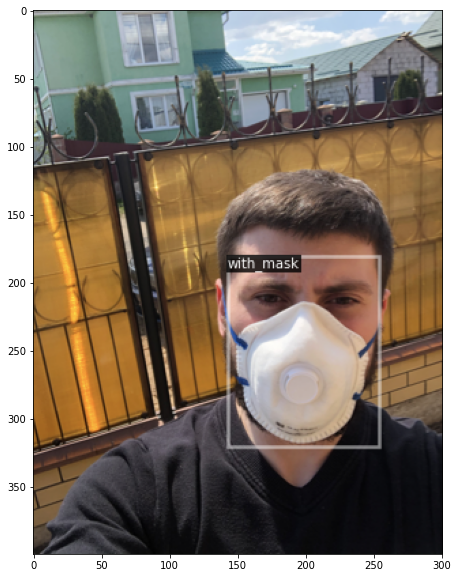

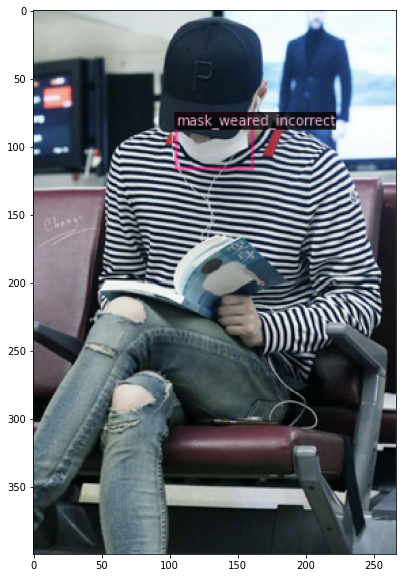

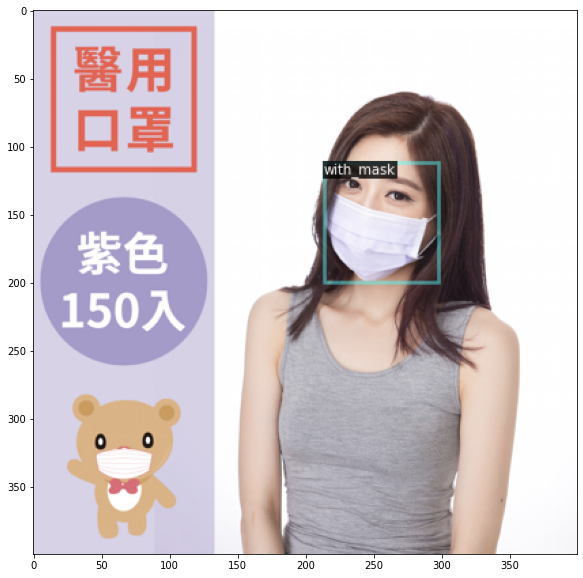

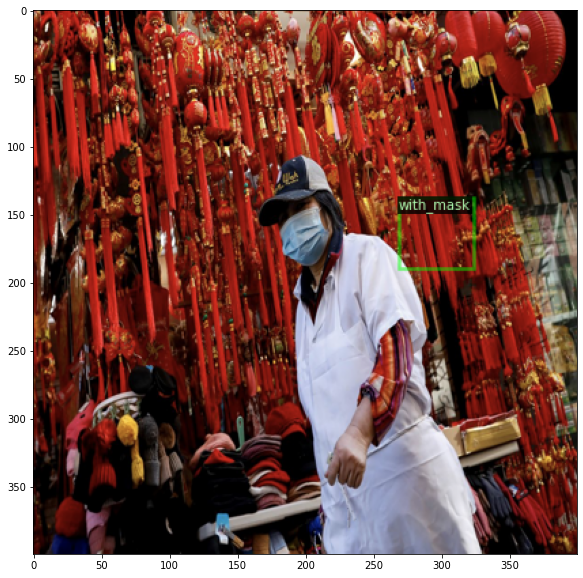

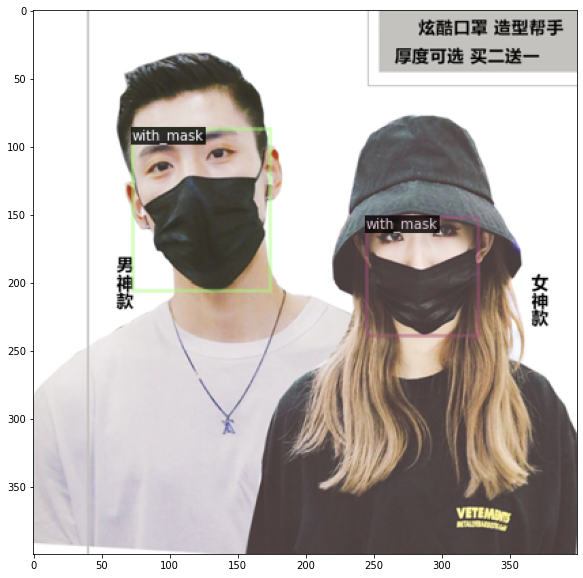

In [8]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('train')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mask_metadata)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (10, 10))
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Creation et entrainement du modèle

Nous allons utiliser le modèle <b>Faster RCNN X101 FPN 3x</b> qui est l'un des plus puissants modèles de détection d'objet implémentés par détection2.

In [9]:
# Model configuration and hyperparameters
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()       # Here you can specify you validation set
cfg.MODEL.DEVICE='cpu'       # I do not have a gpu
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001   # pick a good LR depending on the size of your dataset and the weight you want to give it.
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 300   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

# Create the output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create the trainer --> object that will train your model
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

# Train your model
trainer.train()

[04/30 17:00:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/mounta/Bureau/Personal repositories/Projects/Computer Vision/Object Detection And Segmentation/mask/environment/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/30 17:21:11 d2.utils.events]:  eta: 1:23:33  iter: 219  total_loss: 0.5465  loss_cls: 0.1619  loss_box_reg: 0.3459  loss_rpn_cls: 0.007684  loss_rpn_loc: 0.01519  time: 61.6931  data_time: 0.0246  lr: 0.00073027  
[04/30 17:41:18 d2.utils.events]:  eta: 1:02:29  iter: 239  total_loss: 0.4532  loss_cls: 0.1562  loss_box_reg: 0.2703  loss_rpn_cls: 0.004204  loss_rpn_loc: 0.009856  time: 60.9847  data_time: 0.0093  lr: 0.00079687  
[04/30 18:02:05 d2.utils.events]:  eta: 0:41:46  iter: 259  total_loss: 0.4676  loss_cls: 0.113  loss_box_reg: 0.3134  loss_rpn_cls: 0.003576  loss_rpn_loc: 0.01386  time: 61.4434  data_time: 0.0116  lr: 0.00086347  


# Evaluer le modèle

D'abord, commençons par charger le modèle qu'on vient d'entrainer.

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7                          # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Voyons à quoi ressemble les prédictions données par le modèle

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
/home/mounta/Bureau/Personal repositories/Projects/Computer Vision/Object Detection/mask/environment/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


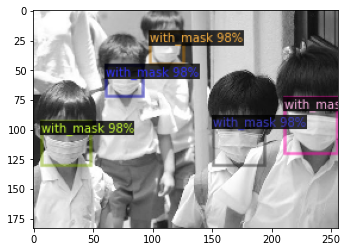

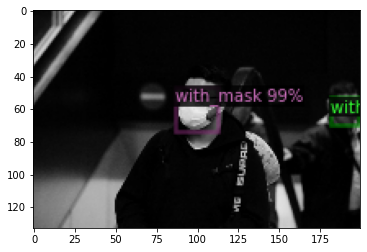

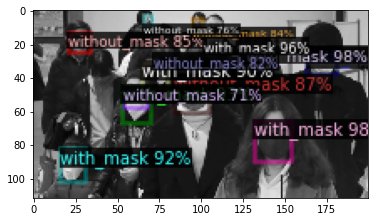

In [11]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get('test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

Evaluons le modèle sur le jeu de données de test.

In [13]:
# Create the output file
os.makedirs('output_test')

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("test", output_dir="./output_test")
val_loader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[04/30 20:52:50 d2.evaluation.coco_evaluation]: Trying to convert 'test' to COCO format ...
[04/30 20:52:50 d2.data.datasets.coco]: Converting annotations of dataset 'test' to COCO format ...)
[04/30 20:52:50 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/30 20:52:50 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 614
[04/30 20:52:50 d2.data.datasets.coco]: Caching COCO format annotations at './output_test/test_coco_format.json' ...
[04/30 20:52:50 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |   category   | #instances   |   category    | #instances   |
|:----------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
| with_mask  | 506          | without_mask | 88           | mask_weared.. | 20           |
|            |              |              |              |               |              |
|   total    | 614          |              |              |          

Nous avons atteint une précision mAP = 38.64, ce qui est pas mal pour un modèle entrainé sur un jeu de données relativement petit et seulement pour 300 epochs.

On pourra envisager d'augmenter le jeu de données et de re-entrainer le modèle sur plus d'epochs.